In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from os import listdir


In [2]:
from scipy import misc

In [3]:
'''Load data'''

IMAGE_FOLDER = "../data/anime wallpapers"
image_png_names = listdir(IMAGE_FOLDER + "/png")
image_jpg_names = listdir(IMAGE_FOLDER + "/jpg")
image_png_paths = [IMAGE_FOLDER + '/png/' + name for name in image_png_names]
image_jpg_paths = [IMAGE_FOLDER + '/jpg/' + name for name in image_jpg_names]

In [5]:
#  list of files to read


In [8]:
png_data = tf.placeholder(dtype=tf.string)
my_img = tf.image.decode_png(png_data, channels=3)

In [9]:
with tf.Session() as sess: 
    
    filename_queue = tf.train.string_input_producer(image_png_paths) 
    reader = tf.WholeFileReader()
    init = tf.initialize_all_variables()
    sess.run(init)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    key, value = reader.read(filename_queue)
    result = sess.run(my_img, feed_dict = {png_data: value})
    
    print(result.shape)
    
    coord.request_stop()
    coord.join(threads)

TypeError: The value of a feed cannot be a tf.Tensor object. Acceptable feed values include Python scalars, strings, lists, or numpy ndarrays.

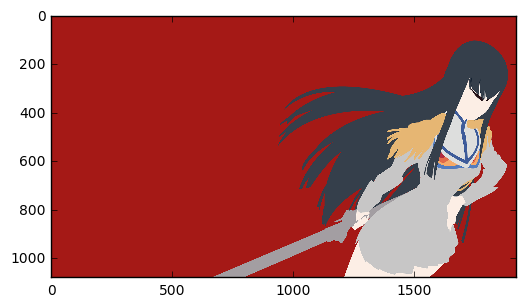

In [10]:
plt.imshow(result)

In [ ]:
print("hi")